<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 15.9 MB/s eta 0:00:00


In [2]:
# 1) Install dependencies (in Colab you’d run these once):
# !pip install astroquery pandas pillow

import os
import numpy as np
import pandas as pd
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from PIL import Image
import matplotlib.pyplot as plt


# 2) Download the debiased GZ2 Table 1 (Hart et al. 2016)
#    This CSV has ~240 000 galaxies with ra, dec, dr7objid, and vote fractions.
url = 'https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz'
df = pd.read_csv(url, compression='gzip')
# :contentReference[oaicite:0]{index=0}

# 3) Sample a small set for our tutorial (e.g. 20 galaxies)
df_sample = df.sample(n=20, random_state=42)[['dr7objid','ra','dec']]

# 4) Create a directory to save your cutouts
os.makedirs('cutouts', exist_ok=True)




In [8]:
# 5) Fetch and save RGB cutouts from SDSS
for _, row in df_sample.iterrows():
    objid = int(row['dr7objid'])
    ra, dec = row['ra'], row['dec']
    pos = coords.SkyCoord(ra, dec, unit=u.deg)
    try:
        # get_images returns a list of HDULists in the order of the 'band' list
        hdulists = SDSS.get_images(pos, band=['g','r','i'],)
        # assemble an (64×64×3) array
        rgb = np.stack([hdulist[0].data for hdulist in hdulists], axis=-1)
        # normalize to 0–255 for display
        norm = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))
        img8 = (norm * 255).astype(np.uint8)
        Image.fromarray(img8).save(f'cutouts/{objid}.png')
    except Exception as e:
        print(f"Failed to fetch {objid}: {e}")

Failed to fetch 587736542021812480: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 588009370152927360: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 588017627774713984: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 588007005259890816: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 587734893829423232: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 587741489829314688: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 587741603109667072: SDSSClass.get_images() takes 1 pos

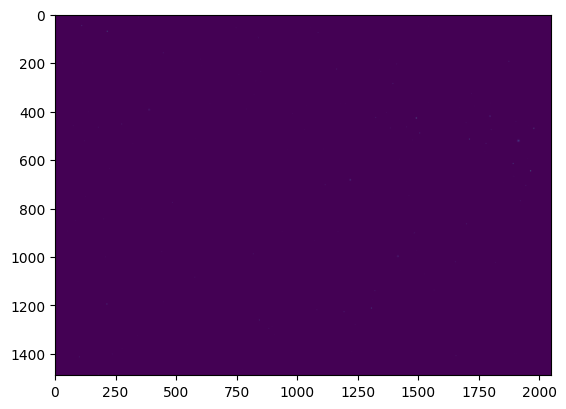

In [46]:
plt.imshow(rgb[:,:,1])


In [22]:
import os
import requests
from PIL import Image
from io import BytesIO

# 1. Helper to fetch an SDSS JPEG cutout
def fetch_sdss_cutout(ra, dec, scale=0.2, width=64, height=64, timeout=60):
    url = "https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
    params = {
        'ra': ra,
        'dec': dec,
        'scale': scale,
        'width': width,
        'height': height,
    }
    r = requests.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return Image.open(BytesIO(r.content))

# 2. Example: loop over your df_sample and save PNGs
imgs = []

for _, row in df_sample.iterrows():
    objid = int(row['dr7objid'])
    ra, dec = row['ra'], row['dec']
    try:
        img = fetch_sdss_cutout(ra, dec,
                                scale=0.2,   # ~0.2″/px
                                width=128,
                                height=128)

        img = np.array(img)
        img = np.mean(img, axis=2)
        imgs.append(img)
    except Exception as e:
        print(f"Failed {objid}: {e}")


In [19]:
# extract image data and make greyscale
data = np.array(img)
d = np.mean(data, axis=2)
d

array([[3.        , 2.33333333, 1.66666667, ..., 5.66666667, 4.33333333,
        3.66666667],
       [3.66666667, 3.        , 2.33333333, ..., 4.66666667, 3.66666667,
        3.        ],
       [4.66666667, 3.66666667, 3.        , ..., 3.33333333, 2.        ,
        2.        ],
       ...,
       [7.        , 7.        , 7.        , ..., 7.33333333, 8.66666667,
        8.66666667],
       [4.66666667, 4.66666667, 5.66666667, ..., 6.33333333, 6.66666667,
        7.66666667],
       [3.66666667, 3.66666667, 4.66666667, ..., 5.33333333, 5.66666667,
        5.66666667]])

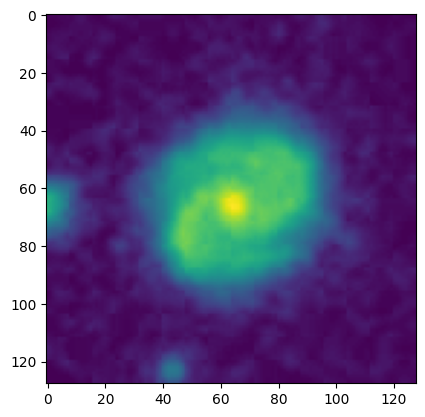

In [29]:
plt.imshow(imgs[15])

In [21]:
df

,dr7objid,ra,dec,rastring,decstring,sample,gz2_class,total_classifications,total_votes,t01_smooth_or_features_a01_smooth_count,...,t11_arms_number_a36_more_than_4_fraction,t11_arms_number_a36_more_than_4_weighted_fraction,t11_arms_number_a36_more_than_4_debiased,t11_arms_number_a36_more_than_4_flag,t11_arms_number_a37_cant_tell_count,t11_arms_number_a37_cant_tell_weight,t11_arms_number_a37_cant_tell_fraction,t11_arms_number_a37_cant_tell_weighted_fraction,t11_arms_number_a37_cant_tell_debiased,t11_arms_number_a37_cant_tell_flag
0,587732591714893851,179.042984,60.522518,11:56:10.32,+60:31:21.1,original,Sc+t,45,342,0,...,0.450,0.450,0.482646,0,16,16.0,0.400,0.400,0.394506,0
1,588009368545984617,135.084396,52.494240,09:00:20.26,+52:29:39.3,original,Sb+t,42,332,1,...,0.512,0.503,0.504833,0,13,13.0,0.317,0.323,0.322743,0
2,587732484359913515,183.371979,50.741508,12:13:29.27,+50:44:29.4,original,Ei,36,125,28,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
3,587741723357282317,186.251953,28.558598,12:25:00.47,+28:33:31.0,original,Sc+t,28,218,1,...,0.240,0.240,0.241322,0,6,6.0,0.240,0.240,0.239765,0
4,587738410866966577,161.086395,14.084465,10:44:20.73,+14:05:04.1,original,Er,43,151,33,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239690,587741490371625059,167.542648,28.991867,11:10:10.23,+28:59:30.7,extra,Ec,42,135,34,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
239691,587731174917669027,316.108826,1.214799,21:04:26.12,+01:12:53.3,stripe82,Ei(i),46,186,25,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
239692,587731512070177108,21.690212,-0.546427,01:26:45.65,+00:32:47.1,stripe82,Ei,48,164,36,...,0.000,0.000,0.000000,0,2,2.0,1.000,1.000,1.000000,1
239693,587731513145688256,25.747143,0.360079,01:42:59.31,+00:21:36.3,stripe82,Ei(i),48,204,25,...,0.000,0.000,0.000000,0,0,0.0,0.000,0.000,0.000000,0
